<a href="https://colab.research.google.com/github/MonitSharma/Quantum-Finance-and-Numerical-Methods/blob/main/Pricing_Fixed_Incoming_Assets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pricing Fixed-Income Assets


## Introduction

We seek to price a fixed-income asset knowing the distributions describing the relevant interest rates. The cash flows $c_t$ of the asset and the dates at which they occur are known and the total value $V$ of the asset is thus expectation value of:

$$ V = \sum_{t=1}^T \frac{c_t}{(1+r_t)^t} $$

------

Each cash flow is treated as a zero coupon bond with a corresponding interest rate $r_t$ that depends on its maturity. The user must specify the distribution modeling the uncertainty in each $r_t$ as well as the number of qubits required.


--------


The approximation of the objective function follows the following paper:

[Quantum Risk Analysis](https://arxiv.org/abs/1806.06893)

In [ ]:
%pip install qiskit[finance]

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_finance.circuit.library import NormalDistribution

### Cicruit Library

`qiskit_finance.circuit.library`



#### Payoff Functions

1. `EuropeanCallDeltaObjective(num)state_qubits,...)`

2. `EuropeanCallPricingObjective(...)`

3. `FixedIncomePricingObjective(num_qubits...)`


-------
--------




#### Probability Distribution


1. `GaussianConditionalIndependenceModel(...)` - The Gaussian Conditional Independence for Credit Risk

`CLASSGaussianConditionalIndependenceModel(n_normal, normal_max_value, p_zeros, rhos)`

The Gaussian Conditional Independence Model for Credit Risk. Reference: https://arxiv.org/abs/1412.1183 Dependency between individual risk variables and latent variable is approximated linearly.


-----



2. `LogNormalDistribution()` - A circuit to encode a discretized log-normal distribution in qubit amplitudes

[Here](https://qiskit.org/documentation/finance/locale/bn_BN/stubs/qiskit_finance.circuit.library.LogNormalDistribution.html#qiskit_finance.circuit.library.LogNormalDistribution)


`CLASSLogNormalDistribution(num_qubits, mu=None, sigma=None, bounds=None, upto_diag=False, name='P(X)')`

A circuit to encode a discretized log-normal distribution in qubit amplitudes.

A random variable $X$ is log-normal distributed if 
$$\log(X) \sim \mathcal{N}(\mu, \sigma^2)$$

for a normal distribution $ \mathcal{N}(\mu, \sigma^2) $.   The probability density function of the log-normal distribution is defined as

$$ \mathbb{P}(X = x) = \frac{1}{x\sqrt{2\pi\sigma^2}} e^{-\frac{(\log(x) - \mu)^2}{\sigma^2}} $$


The parameter `sigma` in this class equals the **variance**, $\sigma^2$ and not the standard deviation. This is for consistency with multivariate distributions, where the uppercase sigma $\Sigma$, , is associated with the covariance.


The circuit considers the discretized version of $X$ on `2** num_qubits` equidistant points, $x_i$ trunctaed to `bounds`. The action of this circuit can be written as 

$$ \mathcal{P}_X |0\rangle^n = \sum_{i=0}^{2^n - 1} \sqrt{\mathbb{P}(x_i)} |i\rangle $$

where $n$ is the number of qubits.


The circuit loads the square root of the probabilities into the qubit amplitudes such that the sampling probability, which is the square of the amplitude, equals the probability of the distribution.

This circuit is for example used in amplitude estimation applications, such as finance, where customer demand or the return of a portfolio could be modeled using a log-normal distribution




-----



3. `NormalDistribution()` - A circuit to enocde a discretized normal distribution in qubit amplitudes

[Here](https://qiskit.org/documentation/finance/locale/bn_BN/stubs/qiskit_finance.circuit.library.NormalDistribution.html#qiskit_finance.circuit.library.NormalDistribution)

`CLASSNormalDistribution(num_qubits, mu=None, sigma=None, bounds=None, upto_diag=False, name='P(X)')`


A circuit to encode a discretized normal distribution in qubit amplitudes.

The probability density function of the normal distribution is defined as

$$\mathbb{P}(X = x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{\sigma^2}}$$


-----



4. `UniformDistribution()` - A circuit to encode a discretized uniform distribution in qubit amplitudes

`CLASS UniformDistribution(num_qubits, name = "P(x)")`

This simply corresponds to applying Hadamard gates on all qubits. The Probability density function of the discretized uniform distributin on $N$ values:

$$ \mathbb{P}(X = x) = \frac{1}{N}. $$

This circuit considers $N= 2^n$ where $n = \text{num_qubits}$ and prepares the state:

$$ \mathcal{P}_X |0\rangle^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n - 1} |x\rangle $$





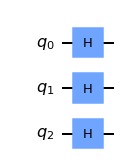

In [7]:
# uniform Distribution
from qiskit_finance.circuit.library.probability_distributions import UniformDistribution
circuit = UniformDistribution(3)
circuit.decompose().draw('mpl')

In [8]:
# log normal

from qiskit_finance.circuit.library.probability_distributions import LogNormalDistribution
mu = [1, 0.9, 0.2]
sigma = [[1, -0.2, 0.2], [-0.2, 1, 0.4], [0.2, 0.4, 1]]
circuit = LogNormalDistribution([2, 2, 2], mu, sigma)
circuit.num_qubits

6

## Uncertainity Model

We construct a circuit to load a multivariate normal random distribution in $d$ dimensions into a quantum state. The distribution is truncated to a given box $\otimes_{i=1}^d [low_i, high_i]$ and discretized using $2^{n_{i}}$ grid points, where $n_i$ denotes the number of qubits used for dimension $i = 1,...,d$. The unitary operator corresponding to the ciruit implements the following:

$$ \big|0\rangle_{n_1}\ldots\big|0\rangle_{n_d} \mapsto \big|\psi\rangle = \sum_{i_1=0}^{2^n_-1}\ldots\sum_{i_d=0}^{2^n_-1} \sqrt{p_{i_1,...,i_d}}\big|i_1\rangle_{n_1}\ldots\big|i_d\rangle_{n_d}, $$

where $p_{i_1, ..., i_d}$  denote the probabilities corresponding to the truncated and discretized distribution and where $i_j$ is mapped to the right interval $[low_j, high_j]$ using the affine map:


$$ \{0, \ldots, 2^{n_{j}}-1\} \ni i_j \mapsto \frac{high_j - low_j}{2^{n_j} - 1} * i_j + low_j \in [low_j, high_j]. $$

In addititon to the unertainty model, we can also apply an affine map, e.g resulting from a principal component analysis. The interest rates used are then given by:

$$ \vec{r} = A * \vec{x} + b, $$

where $\vec{x} \in \otimes_{i=1}^d [low_i, high_i]$ follows the given random distribution.

In [9]:
# can be used in case a Principal Component Analysis has been done to derive
# the uncertainty model, ignored in this one
A = np.eye(2)
b = np.zeros(2)


# specify the nymber of qubits that are used to
# represent the different dimensions of the
# uncertainty model

num_qubits = [2,2]

# specify the lower and upper bounds for the different dimensions
low = [0,0]
high = [0.12, 0.24]
mu = [0.12, 0.24]
sigma = 0.01 * np.eye(2)


# construct corresponding distribution
bounds = list(zip(low,high))
u = NormalDistribution(num_qubits, mu, sigma, bounds)

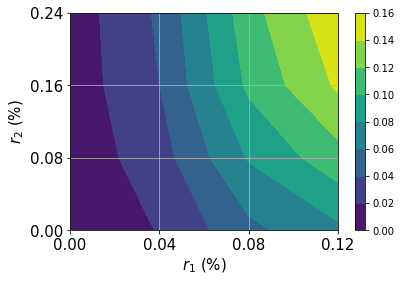

In [10]:
# plot contour of probability density function
x = np.linspace(low[0], high[0], 2 ** num_qubits[0])
y = np.linspace(low[1], high[1], 2 ** num_qubits[1])
z = u.probabilities.reshape(2 ** num_qubits[0], 2 ** num_qubits[1])
plt.contourf(x, y, z)
plt.xticks(x, size=15)
plt.yticks(y, size=15)
plt.grid()
plt.xlabel("$r_1$ (%)", size=15)
plt.ylabel("$r_2$ (%)", size=15)
plt.colorbar()
plt.show()

## Cash flow, payoff function , and exact expected value

In the following we define the cash flow per period, the resulting payoff function and evaluate the exact expected value.


For the payoff function we first order approximation and then apply the same approximation technique as for the pay off function of the `European Call Option`



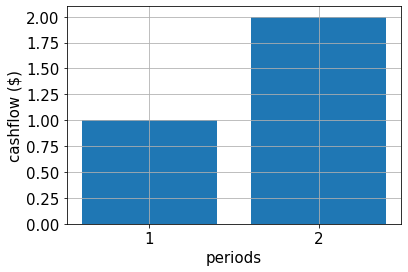

In [11]:
# specify cash flow
cf = [1.0, 2.0]
periods = range(1, len(cf) + 1)

# plot cash flow
plt.bar(periods, cf)
plt.xticks(periods, size=15)
plt.yticks(size=15)
plt.grid()
plt.xlabel("periods", size=15)
plt.ylabel("cashflow ($)", size=15)
plt.show()

In [12]:
# estimate real value
cnt = 0
exact_value = 0.0
for x1 in np.linspace(low[0], high[0], pow(2, num_qubits[0])):
    for x2 in np.linspace(low[1], high[1], pow(2, num_qubits[1])):
        prob = u.probabilities[cnt]
        for t in range(len(cf)):
            # evaluate linear approximation of real value w.r.t. interest rates
            exact_value += prob * (
                cf[t] / pow(1 + b[t], t + 1)
                - (t + 1) * cf[t] * np.dot(A[:, t], np.asarray([x1, x2])) / pow(1 + b[t], t + 2)
            )
        cnt += 1
print("Exact value:    \t%.4f" % exact_value)

Exact value:    	2.1942


In [13]:
# specify approximation factor
c_approx = 0.125

# create fixed income pricing application
from qiskit_finance.applications.estimation import FixedIncomePricing

fixed_income = FixedIncomePricing(
    num_qubits=num_qubits,
    pca_matrix=A,
    initial_interests=b,
    cash_flow=cf,
    rescaling_factor=c_approx,
    bounds=bounds,
    uncertainty_model=u,
)

In [14]:
%pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


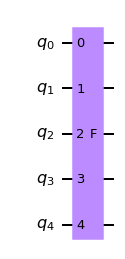

In [15]:
fixed_income._objective.draw('mpl')

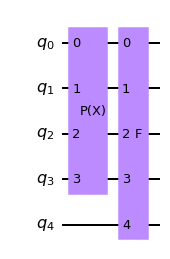

In [17]:
fixed_income_circ = QuantumCircuit(fixed_income._objective.num_qubits)

# load probability distribution
fixed_income_circ.append(u, range(u.num_qubits))

# apply function
fixed_income_circ.append(fixed_income._objective, range(fixed_income._objective.num_qubits))

fixed_income_circ.draw('mpl')

In [18]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)

problem = fixed_income.to_estimation_problem()

ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [19]:
result = ae.estimate(problem)

In [20]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (fixed_income.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	2.1942
Estimated value:    	2.3415
Confidence interval:	[2.2929, 2.3902]
